In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import img_to_array, load_img


from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from skimage import exposure
from skimage import color

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, Adamax
from keras.layers import Input, UpSampling2D, Conv2D, concatenate, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import load_img, img_to_array
from keras.regularizers import l1, l2

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input # Changed import path

import os
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


2024-10-16 15:16:01.527035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Create a Model


In [4]:
def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(20, (5, 5), strides=1, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), strides=1, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(40, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Activation('relu'))
    
    model.add(layers.Flatten())

    # Dense layer with 2 output units (for binary classification)
    model.add(layers.Dense(2))

    # Softmax activation layer for classification
    model.add(layers.Activation('softmax'))

    
    return model

# def create_cnn_model(input_shape):
#     model = models.Sequential()
#     model.add(layers.Conv2D(20, (5, 5), strides=1, activation='relu', input_shape=input_shape))
#     model.add(layers.MaxPooling2D((2, 2)))
    
#     model.add(layers.Conv2D(32, (3, 3), strides=1, activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
    
#     model.add(layers.Conv2D(40, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
    
#     model.add(layers.Activation('relu')) #7th
    
#     model.add(layers.Conv2D(40, (4, 4), activation='relu'))
    
#     model.add(layers.MaxPooling2D((2, 2)))

#     # Flatten the output to feed into a fully connected layer
#     model.add(layers.Flatten())

#     # Add a dense layer with 2 units for binary classification (glaucoma vs normal)
#     model.add(layers.Dense(2))

#     # Add the softmax activation for classification
#     model.add(layers.Activation('softmax'))


    
#     return model

input_shape = (48, 48, 1)  # As per your dataset description
model = create_cnn_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 20)        520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        5792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 40)          11560     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 40)         0

In [53]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Example: Load images from a directory and create labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize images to match the input shape of the CNN
            images.append(img)
            labels.append(label)
        
    return images, labels

# '/Users/nemekhbayarnomin/Documents/Graduation_project/dataset/3_dataset/sets_merged_split/classification/test'


In [55]:
def scalar(img):
        return img

train_generator = ImageDataGenerator(preprocessing_function = scalar,
                                     horizontal_flip = True)

test_generator = ImageDataGenerator(preprocessing_function = scalar)

In [5]:
# Load images from the healthy and diseased folders
healthy_images, healthy_labels = load_images_from_folder('dataset\3_dataset\ORG\filtered_images\healthy', 0)
diseased_images, diseased_labels = load_images_from_folder('dataset\3_dataset\ORG\filtered_images\diseased', 1)
print(len(healthy_images), len(diseased_images))

544 544


In [6]:
# Combine the datasets
images = np.array(healthy_images + diseased_images)
labels = np.array(healthy_labels + diseased_labels)

# Normalize the images
images = images / 255.0

# One-hot encode the labels if using 'categorical_crossentropy'
labels = to_categorical(labels, num_classes=2)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [7]:
data_dir = "dataset/3_dataset/filtered_images"

glaucoma_df = pd.DataFrame(columns=['filepaths', 'labels'])
normal_df = pd.DataFrame(columns=['filepaths', 'labels'])

glaucoma_label = 'glaucoma'
normal_label = 'healthy'


glaucoma_files = os.listdir(os.path.join(data_dir, "glaucoma"))
normal_files = os.listdir(os.path.join(data_dir, "healthy"))

glaucoma_df['filepaths'] = [os.path.join(data_dir, "glaucoma", filename) for filename in glaucoma_files]
glaucoma_df['labels'] = glaucoma_label

normal_df['filepaths'] = [os.path.join(data_dir, "healthy", filename) for filename in normal_files]
normal_df['labels'] = normal_label
combined_df = pd.concat([glaucoma_df, normal_df], ignore_index=True)

combined_df = combined_df.sample(frac=1, random_state=42)
label_counts = combined_df['labels'].value_counts()

train_df, dummy_df = train_test_split(combined_df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= combined_df['labels'])

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= dummy_df['labels'])

                            


In [8]:
def scalar(img):
        return img

train_generator = ImageDataGenerator(preprocessing_function = scalar,
                                     horizontal_flip = True)

test_generator = ImageDataGenerator(preprocessing_function = scalar)

Found 870 validated image filenames belonging to 2 classes.


In [9]:
valid_set = test_generator.flow_from_dataframe( valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= (224, 224),
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= 40)


Found 109 validated image filenames belonging to 2 classes.


In [10]:
test_set = test_generator.flow_from_dataframe( test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= (224, 224),
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= 2)

Found 109 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam

model = create_cnn_model(input_shape=(224, 224, 3))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',  # Use binary_crossentropy if labels are not one-hot encoded
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,          # Stop after 3 epochs with no improvement
                               restore_best_weights=True)  # Restore model weights from the best epoch


history = model.fit((X_train, y_train),
                    validation_data=(X_val, y_val),
                    epochs=30,  # Adjust based on your needs
                    batch_size=32,
                    callbacks=[early_stopping]) 

test_loss, test_accuracy = model.evaluate((X_test, y_test))
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

In [11]:
# input shape = (224, 224, 3)

model = create_cnn_model(input_shape=(256, 256, 3))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use binary_crossentropy if labels are not one-hot encoded
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,  # Adjust based on your needs
                    batch_size=64)  # Adjust batch size based on available memory

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10
14/14 [==============================] - 28s 2s/step - loss: 0.7749 - accuracy: 0.4989 - val_loss: 0.6884 - val_accuracy: 0.5321
Epoch 2/10
14/14 [==============================] - 25s 2s/step - loss: 0.6907 - accuracy: 0.5218 - val_loss: 0.6872 - val_accuracy: 0.5413
Epoch 3/10
14/14 [==============================] - 25s 2s/step - loss: 0.6887 - accuracy: 0.5149 - val_loss: 0.6827 - val_accuracy: 0.5321
Epoch 4/10
14/14 [==============================] - 25s 2s/step - loss: 0.6851 - accuracy: 0.5632 - val_loss: 0.6670 - val_accuracy: 0.6147
Epoch 5/10
14/14 [==============================] - 26s 2s/step - loss: 0.6624 - accuracy: 0.6356 - val_loss: 0.6343 - val_accuracy: 0.6330
Epoch 6/10
14/14 [==============================] - 25s 2s/step - loss: 0.6301 - accuracy: 0.6425 - val_loss: 0.6408 - val_accuracy: 0.5688
Epoch 7/10
14/14 [==============================] - 24s 2s/step - loss: 0.6265 - accuracy: 0.6149 - val_loss: 0.6532 - val_accuracy: 0.5872
Epoch 8/10
14/14 [==

In [2]:
# def compute_hog(image):
#     pixels_per_cell = (7, 7)
#     cells_per_block = (2, 2)
#     block_norm = 'L2-Hys'
#     orientations = 9
#     hog_features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
#                        cells_per_block=cells_per_block, block_norm=block_norm, visualize=False,
#                        feature_vector=True)
#     return hog_features
# Accuracy with pixels_per_cell=(12, 12), cells_per_block=(2, 2), orientations=9: 0.7799

# best parameters found by Bayesian optimization
# cells_per_block= 3 does not work cox it overflow
def compute_hog(image):
    pixels_per_cell = (12, 12)
    cells_per_block = (2, 2)
    block_norm = 'L2-Hys'
    orientations = 9
    hog_features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, block_norm=block_norm, visualize=False,
                       feature_vector=True)
    return hog_features



In [3]:
# Constants for LBP
LBP_RADIUS = 2
LBP_N_POINTS = 16



def compute_lbp(image):
    lbp = local_binary_pattern(image, P=LBP_N_POINTS, R=LBP_RADIUS, method='default')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 2**LBP_N_POINTS + 1), range=(0, 2**LBP_N_POINTS))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

In [5]:

def compute_sift(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        descriptors = descriptors.flatten()[:128]
        if descriptors.shape[0] < 128:
            descriptors = np.pad(descriptors, (0, 128 - descriptors.shape[0]), 'constant')
    else:
        descriptors = np.zeros(128)
    return descriptors

**Try feat_cnn_model with tuned hog parameters on classfication**

In [11]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# # Define the model architecture
# def build_base_model():
#     inputs = Input(shape=(256, 256, 3))
#     x = Conv2D(64, (5, 5), activation='relu')(inputs)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(16, (5, 5), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(48, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Flatten(name='flatten_1')(x)
#     outputs = Dense(2, activation='softmax')(x)
#     model = Model(inputs, outputs)
#     return model

# # Initialize the model
# base_model = build_base_model()

# # Load weights into the model
# base_model.load_weights('/Users/nemekhbayarnomin/Documents/Graduation_project/Report_Final/feat_cnn_model_softmax_fundus_256_colab.h5')

# # Create a feature extraction model from the desired layer (e.g., 'flatten_1')
# def create_cnn_feature_extractor(model, layer_name='flatten_1'):
#     feature_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
#     return feature_model

# # Create the feature extractor model
# feature_extractor = create_cnn_feature_extractor(base_model, layer_name='flatten_1')
# feature_extractor.summary()

from tensorflow.keras.models import load_model
original_model = load_model('feat_cnn_model_softmax_fundus_256_colab.h5')
original_model.summary()


TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [10]:
# base_model.summary()

In [8]:
def process_and_extract_features_from_folders(image_folder):
    hog_features_list = []
    lbp_features_list = []
    cnn_features_list = []
    sift_features_list = []
    labels = []

    for label_folder in os.listdir(image_folder):
        folder_path = os.path.join(image_folder, label_folder)
        if not os.path.isdir(folder_path):
            continue

        for image_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, image_name)

            # Read the image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image at {img_path}. Skipping.")
                continue
            
            img = cv2.resize(img, (224, 224))
            
            # Prepare image for CNN feature extraction
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Extract CNN features using the modified model
            cnn_features = model.predict(img_array).flatten()  # Output is already flat
            cnn_features_list.append(cnn_features)

            # Process for HOG, LBP, and SIFT
            img_resized = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_resized is None:
                print(f"Warning: Unable to read grayscale image at {img_path}. Skipping.")
                continue

            hog_features_list.append(compute_hog(img_resized).flatten())
            lbp_features_list.append(compute_lbp(img_resized).flatten())
            sift_features_list.append(compute_sift(img_resized).flatten())

            # Store the label
            labels.append(label_folder)
    
    return {
            'HOG': np.array(hog_features_list),
            'LBP': np.array(lbp_features_list),
            'CNN': np.array(cnn_features_list),
            'SIFT': np.array(sift_features_list)
        }, np.array(labels)


In [9]:
# import os
# import random
# import shutil

# def copy_random_half_images(src_folder, dest_folder):
#     # Ensure the destination folder exists
#     os.makedirs(dest_folder, exist_ok=True)
    
#     # Get the list of all image files in the source folder
#     image_files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
    
#     # Calculate half the total number of images
#     half_length = len(image_files) // 2
    
#     # Randomly select half of the images
#     random_half_files = random.sample(image_files, half_length)
    
#     # Copy each randomly selected image to the destination folder
#     for image_file in random_half_files:
#         src_path = os.path.join(src_folder, image_file)
#         dest_path = os.path.join(dest_folder, image_file)
#         shutil.copy(src_path, dest_path)
#         print(f"Copied: {image_file}")

#     print(f"Successfully copied {half_length} images to {dest_folder}.")

# # Example usage
# src_folder = '/Users/nemekhbayarnomin/Documents/Graduation_project/dataset/3_dataset/roi_full_rgb_labeled/half/healthy'
# dest_folder = '/Users/nemekhbayarnomin/Documents/Graduation_project/dataset/3_dataset/roi_full_rgb_labeled/half/half/healthy'

# copy_random_half_images(src_folder, dest_folder)


In [10]:

image_folder = 'dataset/3_dataset/filtered_images'
# Process images and extract features
features_dict, labels = process_and_extract_features_from_folders(image_folder)

print("Feature extraction and normalization completed.")
# print("Features shape:", features_dict.shape)
print("Labels shape:", labels.shape)

1/1 [==============================] - 0s 136ms/step
Feature extraction and normalization completed.
Labels shape: (9846,)


In [14]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
encoded_labels_dict = label_encoder.fit_transform(labels)
    
print(encoded_labels_dict)

[0 0 0 ... 1 1 1]


In [15]:
y_training = pd.DataFrame(encoded_labels_dict) 
print(y_training)


      0
0     0
1     0
2     0
3     0
4     0
...  ..
9841  1
9842  1
9843  1
9844  1
9845  1

[9846 rows x 1 columns]


In [12]:
from sklearn.svm import SVC                         # Support Vector Machine
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.neighbors import KNeighborsClassifier   # K-Nearest Neighbors
from sklearn.neural_network import MLPClassifier     # Multi-Layer Perceptron
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.naive_bayes import GaussianNB           # Gaussian Naive Bayes
from xgboost import XGBClassifier                    # Extreme Gradient Boosting
import lightgbm as lgb 

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import numpy as np
import itertools
import time
from sklearn.decomposition import PCA
from mrmr import mrmr_classif
from xgboost import XGBClassifier
import lightgbm as lgb
import itertools


In [16]:
y_training = pd.DataFrame(encoded_labels_dict) 

# Evaluation Metrics
# Evaluation Metrics
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    return accuracy, precision, recall, f1

# Classifiers to evaluate (only top performers)
classifiers = {
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
#     'GaussianNB': GaussianNB(),
#     'XGB': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
#     'LightGBM': lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}


# PCA and computing combinations
feature_keys = ['HOG', 'LBP', 'CNN', 'SIFT']
combinations = []
for i in range(1, len(feature_keys) + 1):
    combinations.extend(itertools.combinations(feature_keys, i))

pca_transformed_features = {}

# Loop through each feature combination
for feature_combination in combinations:
    # Concatenate selected features
    combined_features = np.hstack([features_dict[key] for key in feature_combination])
    
    # Normalize the features
    scaler = StandardScaler()
    combined_features_normalized = scaler.fit_transform(combined_features)
    
    # Apply PCA to reduce the dimensionality
    pca = PCA(n_components=min(100, combined_features_normalized.shape[1]))  # Example to keep top 100 components or fewer
    combined_features_pca = pca.fit_transform(combined_features_normalized)
    
    # Store the PCA-transformed features
    pca_transformed_features['+'.join(feature_combination)] = combined_features_pca

# Results list to store evaluation results
results = []

# Initialize highest accuracy tracker
highest_acc = {
    'Classifier': None,
    'Accuracy': 0.0,
    'Features': None
}

# Loop through each feature combination stored in pca_transformed_features
for feature_combination_str, combined_features_selected in pca_transformed_features.items():
    # Normalize features
    scaler = StandardScaler()
    combined_features = scaler.fit_transform(combined_features_selected)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(combined_features, y_training, test_size=0.2, random_state=42)
    
    for clf_name, clf in classifiers.items():
        start_time = time.time()
        
        # Train and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred, clf_name)
        computation_time = time.time() - start_time
        
        # Update highest accuracy if current accuracy is better
        if accuracy > highest_acc['Accuracy']:
            highest_acc = {
                'Classifier': clf_name,
                'Accuracy': accuracy,
                'Features': feature_combination_str
            }
        
        # Save the results
        results.append({
            'Classifier': clf_name,
            'Features': feature_combination_str,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Computation Time (s)': computation_time
        })

# Convert results to DataFrame for better visualization
print("Highest Accuracy:", highest_acc)
results_df = pd.DataFrame(results)
print(results_df)





Highest Accuracy: {'Classifier': 'SVM', 'Accuracy': 0.8507614213197969, 'Features': 'HOG+LBP+CNN'}
             Classifier          Features  Accuracy  Precision    Recall  \
0                   SVM               HOG  0.840609   0.822632  0.916816   
1         Random Forest               HOG  0.798985   0.774734  0.910555   
2                   KNN               HOG  0.776650   0.773387  0.857782   
3                   MLP               HOG  0.813706   0.820666  0.859571   
4   Logistic Regression               HOG  0.787817   0.789735  0.853309   
..                  ...               ...       ...        ...       ...   
70                  SVM  HOG+LBP+CNN+SIFT  0.846701   0.833879  0.911449   
71        Random Forest  HOG+LBP+CNN+SIFT  0.815736   0.795615  0.908766   
72                  KNN  HOG+LBP+CNN+SIFT  0.818274   0.807942  0.891771   
73                  MLP  HOG+LBP+CNN+SIFT  0.835533   0.846422  0.867621   
74  Logistic Regression  HOG+LBP+CNN+SIFT  0.792893   0.796823  0

In [17]:
# results_df.to_csv('inception_full_244.csv')
sorted_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
sorted_df.head(10)

,Classifier,Features,Accuracy,Precision,Recall,F1-Score,Computation Time (s)
0,SVM,HOG+LBP+CNN,0.850761,0.836601,0.915921,0.874466,22.787974
1,SVM,HOG+SIFT,0.848223,0.828916,0.923077,0.873466,25.586380
2,SVM,HOG+CNN,0.848223,0.828916,0.923077,0.873466,26.123112
3,SVM,HOG+LBP,0.848223,0.833198,0.915921,0.872603,21.552527
4,SVM,HOG+LBP+SIFT,0.848223,0.831043,0.919499,0.873036,21.288135
5,SVM,HOG+CNN+SIFT,0.847208,0.828112,0.922182,0.872620,25.228356
6,SVM,HOG+LBP+CNN+SIFT,0.846701,0.833879,0.911449,0.870940,21.680325
7,SVM,HOG,0.840609,0.822632,0.916816,0.867174,25.974205
8,MLP,HOG+LBP+CNN+SIFT,0.835533,0.846422,0.867621,0.856890,4.698340
9,MLP,HOG+LBP,0.835025,0.847502,0.864937,0.856131,4.684176


In [20]:
results_df.to_csv('inception_fundus_report_224.csv')

# extract cnn
Results for SVM:
Accuracy: 0.7368
Precision: 0.7408
Recall: 0.7368
F1-Score: 0.7381
              precision    recall  f1-score   support

Non-Glaucoma       0.67      0.72      0.69        39
    Glaucoma       0.79      0.75      0.77        56

    accuracy                           0.74        95
   macro avg       0.73      0.73      0.73        95
weighted avg       0.74      0.74      0.74        95

------------------------------------------------------
Results for Random Forest:
Accuracy: 0.7263
Precision: 0.7260
Recall: 0.7263
F1-Score: 0.7174
              precision    recall  f1-score   support

Non-Glaucoma       0.72      0.54      0.62        39
    Glaucoma       0.73      0.86      0.79        56

    accuracy                           0.73        95
   macro avg       0.73      0.70      0.70        95
weighted avg       0.73      0.73      0.72        95

------------------------------------------------------
Results for KNN:
Accuracy: 0.6211
Precision: 0.6835
Recall: 0.6211
F1-Score: 0.6164
              precision    recall  f1-score   support

Non-Glaucoma       0.52      0.82      0.64        39
    Glaucoma       0.79      0.48      0.60        56

    accuracy                           0.62        95
   macro avg       0.66      0.65      0.62        95
weighted avg       0.68      0.62      0.62        95

------------------------------------------------------

# extract_cnn_lbp_sift_without_resize(50, 50)
Results for SVM:
Accuracy: 0.8105
Precision: 0.8125
Recall: 0.8105
F1-Score: 0.8112
              precision    recall  f1-score   support

Non-Glaucoma       0.76      0.79      0.77        39
    Glaucoma       0.85      0.82      0.84        56

    accuracy                           0.81        95
   macro avg       0.80      0.81      0.81        95
weighted avg       0.81      0.81      0.81        95

------------------------------------------------------
Results for Random Forest:
Accuracy: 0.7474
Precision: 0.7452
Recall: 0.7474
F1-Score: 0.7449
              precision    recall  f1-score   support

Non-Glaucoma       0.71      0.64      0.68        39
    Glaucoma       0.77      0.82      0.79        56

    accuracy                           0.75        95
   macro avg       0.74      0.73      0.73        95
weighted avg       0.75      0.75      0.74        95

------------------------------------------------------
Results for KNN:
Accuracy: 0.5474
Precision: 0.7149
Recall: 0.5474
F1-Score: 0.5019
              precision    recall  f1-score   support

Non-Glaucoma       0.47      0.95      0.63        39
    Glaucoma       0.88      0.27      0.41        56

    accuracy                           0.55        95
   macro avg       0.68      0.61      0.52        95
weighted avg       0.71      0.55      0.50        95

------------------------------------------------------

# process_extract _pca=400
Features shape: (472, 134852)
Labels shape: (472,)


Results for SVM:
Accuracy: 0.8105
Precision: 0.8125
Recall: 0.8105
F1-Score: 0.8112
              precision    recall  f1-score   support

Non-Glaucoma       0.76      0.79      0.77        39
    Glaucoma       0.85      0.82      0.84        56

    accuracy                           0.81        95
   macro avg       0.80      0.81      0.81        95
weighted avg       0.81      0.81      0.81        95

------------------------------------------------------
Results for Random Forest:
Accuracy: 0.7474
Precision: 0.7452
Recall: 0.7474
F1-Score: 0.7449
              precision    recall  f1-score   support

Non-Glaucoma       0.71      0.64      0.68        39
    Glaucoma       0.77      0.82      0.79        56

    accuracy                           0.75        95
   macro avg       0.74      0.73      0.73        95
weighted avg       0.75      0.75      0.74        95

------------------------------------------------------
Results for KNN:
Accuracy: 0.5474
Precision: 0.7149
Recall: 0.5474
F1-Score: 0.5019
              precision    recall  f1-score   support

Non-Glaucoma       0.47      0.95      0.63        39
    Glaucoma       0.88      0.27      0.41        56

    accuracy                           0.55        95
   macro avg       0.68      0.61      0.52        95
weighted avg       0.71      0.55      0.50        95

------------------------------------------------------

**I am running this on rgb roi images with cnn model**

Epoch 1/250 - Loss: 0.6271, Accuracy: 0.7711
Epoch 2/250 - Loss: 0.4767, Accuracy: 0.7954
Epoch 3/250 - Loss: 0.4275, Accuracy: 0.8015
Epoch 4/250 - Loss: 0.4023, Accuracy: 0.8051
Epoch 5/250 - Loss: 0.3844, Accuracy: 0.8096
Epoch 6/250 - Loss: 0.3693, Accuracy: 0.8208
Epoch 7/250 - Loss: 0.3556, Accuracy: 0.8223
Epoch 8/250 - Loss: 0.3429, Accuracy: 0.8239
Epoch 9/250 - Loss: 0.3309, Accuracy: 0.8259
Epoch 10/250 - Loss: 0.3194, Accuracy: 0.8289
Epoch 11/250 - Loss: 0.3087, Accuracy: 0.8310
Epoch 12/250 - Loss: 0.2983, Accuracy: 0.8340
Epoch 13/250 - Loss: 0.2885, Accuracy: 0.8365
Epoch 14/250 - Loss: 0.2792, Accuracy: 0.8381
Epoch 15/250 - Loss: 0.2705, Accuracy: 0.8381
Epoch 16/250 - Loss: 0.2622, Accuracy: 0.8365
Epoch 17/250 - Loss: 0.2545, Accuracy: 0.8365
Epoch 18/250 - Loss: 0.2471, Accuracy: 0.8355
Epoch 19/250 - Loss: 0.2400, Accuracy: 0.8345
Epoch 20/250 - Loss: 0.2333, Accuracy: 0.8345
Epoch 21/250 - Loss: 0.2268, Accuracy: 0.8365
Epoch 22/250 - Loss: 0.2206, Accuracy: 0.83

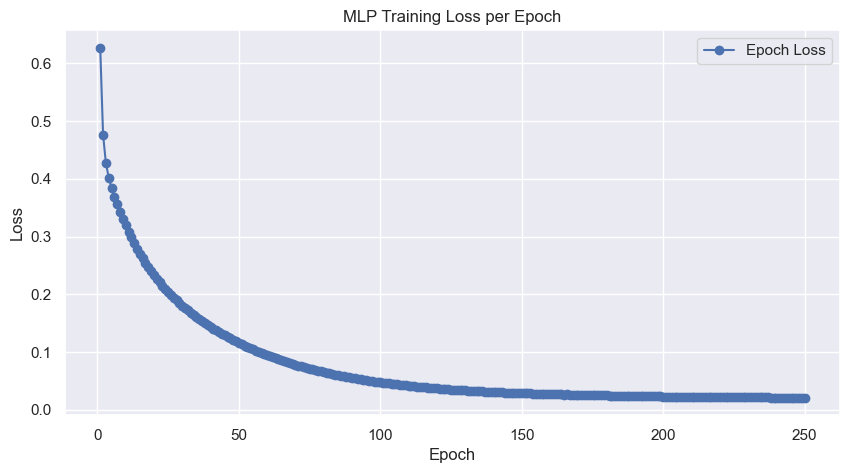

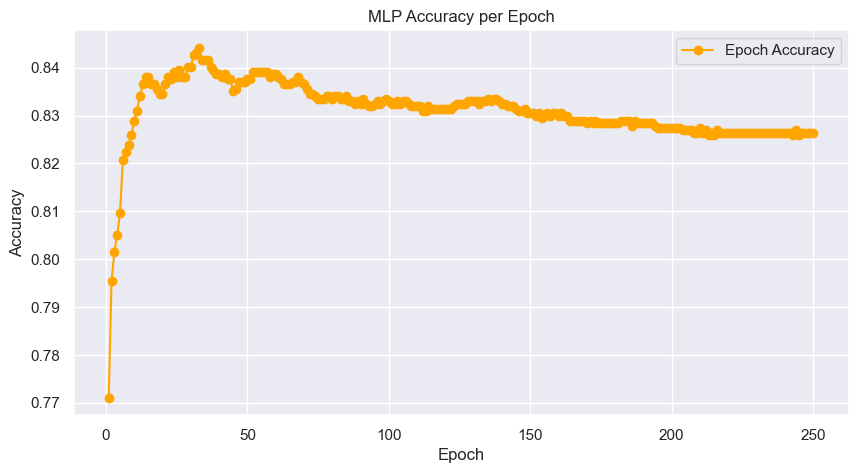

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming combined_features and y_training are prepared and normalized

# Define number of epochs
n_epochs = 250

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y_training, test_size=0.2, random_state=42)

# Initialize MLP with partial_fit capabilities
mlp = MLPClassifier(random_state=42, warm_start=True, max_iter=1)

# Prepare list to store epoch-wise loss and accuracy
epoch_loss = []
epoch_accuracy = []

# Run training for each epoch
for epoch in range(n_epochs):
    # Partial fit to incrementally train the model on batches
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
    
    # Calculate epoch loss
    loss = mlp.loss_
    epoch_loss.append(loss)
    
    # Evaluate on test set
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    epoch_accuracy.append(accuracy)
    
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot the epoch loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), epoch_loss, marker='o', label='Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training Loss per Epoch')
plt.legend()
plt.show()

# Plot the epoch accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), epoch_accuracy, marker='o', color='orange', label='Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP Accuracy per Epoch')
plt.legend()
plt.show()


In [26]:
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt
# from sklearn.tree import DecisionTreeClassifier

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(combined_features_selected, y_training, test_size=0.2, random_state=42)

# # Train the Decision Tree Classifier
# dt_clf = DecisionTreeClassifier(random_state=42)
# dt_clf.fit(X_train, y_train)

# # Plot the Decision Tree



DecisionTreeClassifier(random_state=42)

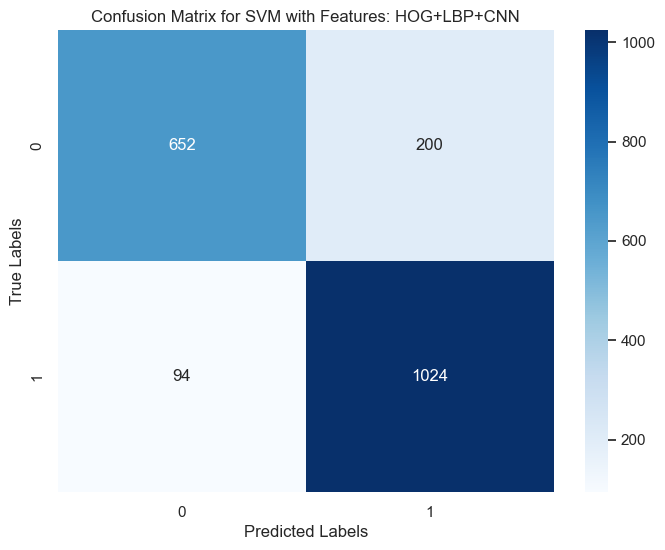

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classifier_name, feature_combination_str):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {classifier_name} with Features: {feature_combination_str}')
    plt.show()

    
# Extract the best-performing classifier and feature combination
best_classifier_name = highest_acc['Classifier']
best_features = highest_acc['Features']

# Recreate the feature set with the best feature combination
best_combined_features = pca_transformed_features[best_features]

# Normalize the features again
scaler = StandardScaler()
best_combined_features = scaler.fit_transform(best_combined_features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(best_combined_features, y_training, test_size=0.2, random_state=42)

# Initialize the best classifier
best_classifier = classifiers[best_classifier_name]

# Train and predict using the best classifier
best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)

# Compute the confusion matrix
best_cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(best_cm, best_classifier_name, best_features)
   




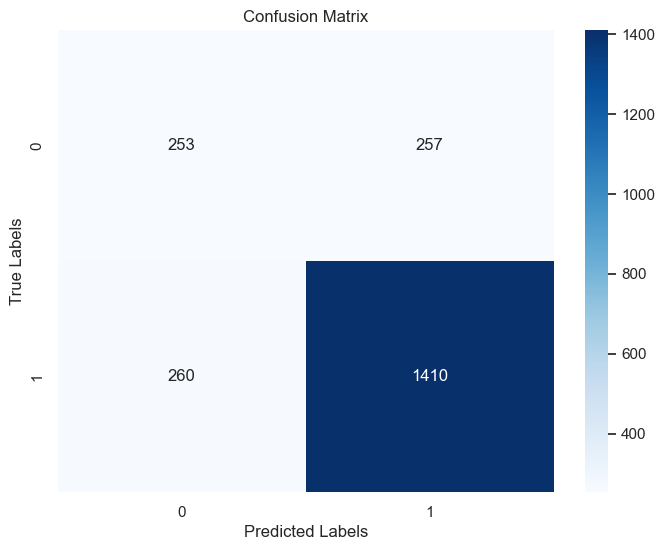

In [11]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from sklearn.metrics import confusion_matrix

# # Confusion matrix values
# TP = 1410
# TN = 253
# FP = 257
# FN = 260

# # Constructing the confusion matrix
# cm = np.array([[TN, FP],
#                [FN, TP]])

# # Visualizing the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')

# # Display the plot
# plt.show()
